# Creating a distance-density graph for London

Implementing a chart from Alain Bertaud's _Order Without Design_ showing the relationship between density and distance from the city centre.

In [48]:
# import dependencies

import pandas as pd
from haversine import haversine
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# import data on property prices and locations

homeprices = pd.read_csv("hpssa202103.csv")

# drop the 2020 column

homeprices = homeprices.drop(columns="hpmd202003")

# drop empty

homeprices = homeprices.dropna(axis = 0)
homeprices["lsoacode"] = homeprices["lsoacode"].astype("string")

# see what happened

homeprices.head()

,lsoacode,hpmd202103
0,E01011949,92692.0
1,E01011950,47887.0
2,E01011951,49176.0
4,E01011953,137600.0
5,E01011954,121214.0


In [14]:
# now we need to attach the pop weighted centroids of LSOAs
# import llsoas centroid database

centroids_import = pd.read_excel("LLSOA_Dec_2021_PWC_for_England_and_Wales_2022_888273117418112309.xlsx")


In [24]:
centroids = centroids_import.drop(columns=["FID", "GlobalID"])
centroids = centroids.rename(columns={"LSOA21CD" : "lsoacode"})
centroids["lsoacode"] = centroids["lsoacode"].astype("string")
centroids.head()

,lsoacode,x,y
0,E01000001,-0.096246,51.519538
1,E01018945,-4.781042,50.457514
2,E01000120,-0.140059,51.632161
3,E01031487,-0.775551,50.855770
4,E01021013,0.603294,50.873093


In [28]:
# now we merge them into one dataframe

df = pd.merge(homeprices, centroids, on="lsoacode", how="inner")

df.head()

,lsoacode,hpmd202103,x,y
0,E01011949,92692.0,-1.228186,54.674248
1,E01011950,47887.0,-1.219376,54.675870
2,E01011951,49176.0,-1.221259,54.678562
3,E01011953,137600.0,-1.227356,54.708389
4,E01011954,121214.0,-1.237867,54.711674


In [35]:
# next, we will calculate distances from charing cross

# Charing Cross coordinates (latitude, longitude)
charing_cross = (51.5074, -0.1278)

# Compute distances using the Haversine formula
df['distance_km'] = df.apply(
    lambda row: haversine((row['y'], row['x']), charing_cross),
    axis=1
)

In [36]:
df.head()

,lsoacode,hpmd202103,x,y,distance_km
0,E01011949,92692.0,-1.228186,54.674248,359.710810
1,E01011950,47887.0,-1.219376,54.675870,359.767580
2,E01011951,49176.0,-1.221259,54.678562,360.085752
3,E01011953,137600.0,-1.227356,54.708389,363.410641
4,E01011954,121214.0,-1.237867,54.711674,363.909798


<Axes: >

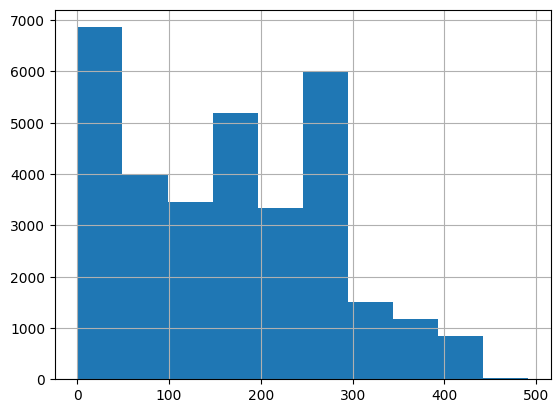

In [39]:
# see the historgram of distances in distance_km

df["distance_km"].hist()

In [54]:
# we want to filter to something closer to London, maybe... 20km?

dff = df[df["distance_km"] <= 100]

dff.head()

,lsoacode,hpmd202103,x,y,distance_km
3374,E01015693,530973.0,-0.414215,51.899532,47.862093
3375,E01015694,381806.0,-0.423910,51.902160,48.406035
3376,E01015695,392278.0,-0.423604,51.898389,48.017564
3377,E01015696,311783.0,-0.413504,51.910061,48.910404
3378,E01015697,313368.0,-0.412452,51.906698,48.539258


/var/folders/gk/w0qjs6r15tqfbz0_dnd5lym40000gn/T/ipykernel_79248/3022395238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['distance_bin'] = pd.cut(dff['distance_km'], bins, right=False)
/var/folders/gk/w0qjs6r15tqfbz0_dnd5lym40000gn/T/ipykernel_79248/3022395238.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices = dff.groupby('distance_bin')['hpmd202103'].mean()


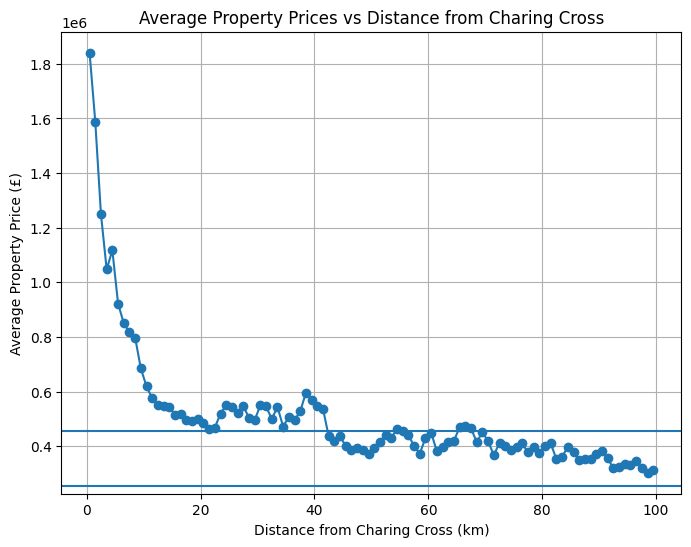

In [57]:
# create bins for distance
bins = np.arange(0, dff['distance_km'].max() + 1, 1)  # 1 km bins
dff['distance_bin'] = pd.cut(dff['distance_km'], bins, right=False)

# calculate average price for each bin
avg_prices = dff.groupby('distance_bin')['hpmd202103'].mean()

# get bin centers for plotting
bin_centers = [interval.mid for interval in avg_prices.index]

# plot density
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, avg_prices, marker='o')
plt.xlabel('Distance from Charing Cross (km)')
plt.ylabel('Average Property Price (£)')
plt.title('Average Property Prices vs Distance from Charing Cross')
plt.grid(True)
plt.axhline(255000) # agricultural land + construction
plt.axhline(455000) # land with pl permission + construction
plt.show()

In [ ]:
# average Uk home consumes 0.5 acre of land
# (very crude I know)
# but, that is 0.005 sq km, and with an agricultural land price of £820,000 per sq km, that is a mere £4,100 in land cost
# and then there is construction costs (£251,000? Housing Forum)
# but planning permission land could be £670,000 per hectare!!
# so £335,000 per 
